[758. 774. 758. 732. 735. 738. 766. 721. 770. 712.]


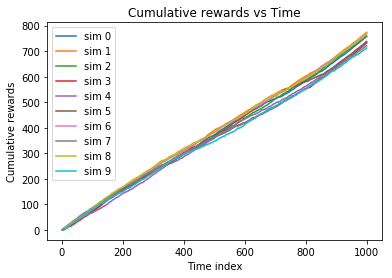

In [4]:
# 아래 코드를 기반으로 자유롭게 수정.
# reward_matrix 형태 수정 금지.
# 강화학습 관련 패키지, 라이브러리, 함수 사용 금지 (예. OpenAI Gym)

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

class adSelector():
    def __init__(self, reward_matrix, values):
        self.N = reward_matrix.shape[0]
        self.T = reward_matrix.shape[1]
        self.num_sims = reward_matrix.shape[2]
        return

    def select_ad(self, state, Q, epsilon, pi_0): # 어떤 광고를 사용자에게 보여줄 것인가
        action_direction = np.arange(N)
        if np.random.rand() < epsilon: # 확률 e로 무작위 행동을 선택함
            action = np.random.choice(action_direction, p=pi_0[state, :])
        else: # Q가 알려주는 방향으로 행동을 선택함
            action = action_direction[np.nanargmax(Q[state, :])]
            
        return action
    
    def get_next_state(self, state, action): # 다음 상태가 무엇인가
        action_direction = np.arange(N)
        s_next = action_direction[action]  # 현재 action에 따른 다음 상태
        
        return s_next

    
### 정책 파라미터 theta_0을 무작위 행동 정책 pi로 변환하는 함수
def simple_convert_into_pi_from_theta(theta):
    '''단순 비율 계산'''
    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 비율 계산

    pi = np.nan_to_num(pi)  # nan을 0으로 변환
    return pi
    
    
### Q러닝 알고리즘으로 행동가치 함수 Q를 수정
def Q_learning(state, action, s_next, reward, Q, eta, gamma=0.01):
    
    if reward is 1: # 언제 Q에게 긍정적인 feedback을 줄 것인가 (현재의 보상이 1일때)
        Q[state, action] = Q[state, action] + eta * (reward - Q[state, action])
    else: # 나머지는 Q에게 부정적인 feedback을 준다. (현재의 보상이 0일때)
        Q[state, action] = Q[state, action] + eta * (reward + gamma*np.nanmax(Q[s_next,:]) - Q[state, action])
    return Q
    
### 테스트 알고리즘
def test_algorithm(algo, reward_matrix, max_epsilon, min_epsilon, eta, gamma):
    N = reward_matrix.shape[0]
    T = reward_matrix.shape[1]
    num_sims = reward_matrix.shape[2]
    cumulative_rewards = np.zeros((num_sims,T))

    for sim in range(num_sims):
        theta_0 = np.ones((N,N)) #initialize 정책 파라미터 (가능한 정책 모두를 표기)
        pi_0 = simple_convert_into_pi_from_theta(theta_0) #initialize 행동 정책 (가능한 정책을 확률로 표현)
        [a, b] = theta_0.shape
        Q = np.random.rand(a, b) * theta_0 * 0.1 #initialize Q
        state = 0 #initialize state
        decreased_epsilon = max_epsilon #initialize epsilon
        
        for t in range(T):
            chosen_ad = algo.select_ad(state, Q, decreased_epsilon, pi_0) #action
            reward = reward_matrix[chosen_ad,t,sim] # 현재 보상
            s_next = algo.get_next_state(state, chosen_ad) # next state
            Q = Q_learning(state, chosen_ad, s_next, reward, Q, eta, gamma) # Q러닝 (현재 보상 사용)
            #print(Q)
            state = s_next # 상태 업데이트
            if max_epsilon >= min_epsilon:
                decreased_epsilon = decreased_epsilon - (max_epsilon - min_epsilon)/T # epsilon 점차적으로 감소
            else:
                print("Max epsilon should bigger than min epsilon")
                raise RuntimeError
            #print(decreased_epsilon)
            
            if t == 0:
                cumulative_rewards[sim,t] = reward
            else:
                cumulative_rewards[sim,t] = cumulative_rewards[sim,t-1] + reward

    return cumulative_rewards



# 훈련집합 (Training set) 생성. 이 부분은 테스트집합으로 변경하여 테스트할 것임.  
N = 3
T = 1000
num_sims = 10

# epsilon과 eta의 변화에 따른 누적 보상값의 차이가 어느정도 존재함.
# 실험적으로 최적의 파라미터를 설정하면 됨.
max_epsilon = 0.1   ### we need this - 무작위 행동 선택 확률
min_epsilon = 0.01  ### we need this
eta = 0.3                ### we need this - learning rate
gamma = 1e-2       ### we need this - parameter of Q learning

reward_matrix = np.zeros((N,T,num_sims))
random.seed(0)
for sim in range(num_sims):
    shuffled_index = np.random.permutation(N)
    reward_matrix[shuffled_index[0],:,sim] = [np.random.binomial(1, p=i/T) for i in range(T)]
    reward_matrix[shuffled_index[1],:,sim] = [np.random.binomial(1, p=1-i/T) for i in range(T)]
    reward_matrix[shuffled_index[2],:,sim] = [np.random.binomial(1, p=3/4) for i in range(T)]

# 학습 알고리즘 테스트.
algo = adSelector(reward_matrix,[])
results = test_algorithm(algo, reward_matrix, max_epsilon, min_epsilon, eta, gamma)  ### we need max&min epsilon, eta, and gamma
print(results[:,T-1])

# 학습 결과를 그래프로 출력.
for i in range(num_sims):
    plt.plot(range(1,T+1), results[i,:], label="sim {}".format(i))
    
plt.plot()
plt.xlabel("Time index")
plt.ylabel("Cumulative rewards")
plt.title("Cumulative rewards vs Time")
plt.legend()
plt.show()
